In [51]:
import pickle
from caiman.utils import visualization
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Batch overview
This notebook reads the results from a batch of preprocessed session and displays statistics and information about them. It can be used to asses the quailty of the preprocessing and pinpoint sessions that need a change in parameters or are not viable for analysis.

## Load data

In [98]:
data_path = Path("/ceph/imaging1/davide/2p_data")
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321',
                           '20230323','20230324','20230328','20230330','2023031'],
            #'441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }


In [99]:
data = {'animal':[],'date':[],'n_cells':[]}
mean_imgs = []
corr_imgs = []
neural_data = []


for animal in sessions.keys():
    print(f'reading data for animal {animal} ...')
    for date in tqdm(sessions[animal]):
        try:
            with open(data_path.joinpath(f'{animal}/{date}/neural_data.pickle'),'rb') as pfile:
                n_data = pickle.load(pfile)
                neural_data.append(n_data)
            with open(data_path.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
                metrics = pickle.load(pfile)
            mean_imgs.append(np.asarray(metrics['mean_image']))
            corr_imgs.append(np.asarray(metrics['corr_image']))

            data['animal'].append(animal)
            data['date'].append(date)
            data['n_cells'].append(len(n_data['traces']))
        
        except FileNotFoundError:
            print(f'Session {animal}/{date} not preprocesses, skipping')
            continue
        
data = pd.DataFrame(data)


reading data for animal 441406_fiano ...


100%|██████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]

Session 441406_fiano/2023031 not preprocesses, skipping


## Metrics overview

In [104]:
def plot_metrics(i):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.title(f'animal: {data.animal.values[i]}, date : {data.date.values[i]}')
    x = mean_imgs[i]
    plt.imshow(x,vmin=np.percentile(x.ravel(),0.05),vmax=np.percentile(x.ravel(),99.95),cmap=plt.cm.gnuplot2)
    contours = neural_data[i]['contour']
    for c in contours:
        plt.plot(*c.T, c='w')
    
    plt.subplot(1,2,2)
    plt.title(f'number of cells: {data.n_cells.values[i]}')
    x = corr_imgs[i]
    plt.imshow(x,vmin=np.percentile(x.ravel(),3),vmax=np.percentile(x.ravel(),97),cmap=plt.cm.gnuplot2)
    for c in contours:
        plt.plot(*c.T, c='w')
    
    
    

In [105]:
from ipywidgets import interact
import ipywidgets as widgets
interact(plot_metrics, i = widgets.IntSlider(min=0, max=len(mean_imgs), value=0))

interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_metrics(i)>

## Number of detected cells

<Axes: xlabel='n_cells', ylabel='Count'>

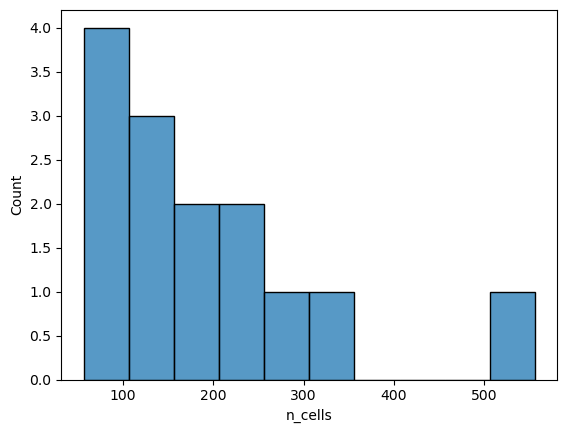

In [100]:
sns.histplot(data=data,x='n_cells',bins=10)